In [2]:
import rasterio
import math
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.windows import Window
import random
from rasterio.plot import reshape_as_raster, reshape_as_image
from glob import glob
import rnn_pixels

In [3]:
def normalize_rgb(tile):
    tile = tile[[2, 1, 0],:,:].astype(np.float64)
    print(tile.shape)
    max_val = 4000
    min_val = 0
    # Enforce maximum and minimum values
    tile[tile[:, :, :] > max_val] = max_val
    tile[tile[:, :, :] < min_val] = min_val
    for b in range(tile.shape[0]):
        tile[b, :, :] = tile[b, :, :] * 1 / (max_val - min_val)
    tile_reshaped = reshape_as_image(tile)
    return tile_reshaped

In [4]:
def view_landsat(landsat):
    #image_dataset = landsat
    full_img = landsat.read()
    colors_reshaped = normalize_rgb(full_img)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(colors_reshaped)
    ax.set_title("RGB in matplotlib imshow")

In [27]:
def make_combined(tile_number, ls8_filepaths, dates, img_fp=None):
    j = 0
    for ls8_fp in ls8_filepaths:
        ls8_band_paths = glob(ls8_fp + '*SRB*')
        ls8_band_paths.sort()
        ls8_band_paths += glob(ls8_fp + '*PIXELQA*')
        if not img_fp:
            img_fp = '/deep_data/recurrent_data/' + 'tile' + tile_number + '/' + 'combined/' + 'combined' +dates[j]+'.tif'
        j+=1
        # Read metadata of first file and assume all other bands are the same
        with rasterio.open(ls8_band_paths[0]) as src0:
            meta = src0.meta
        # Update metadata to reflect the number of layers
        meta.update(count = len(ls8_band_paths)+1) #add 1 because ndvi
        # Read each layer and write it to stack
        with rasterio.open(img_fp, 'w', **meta) as dst:
            for id, layer in enumerate(ls8_band_paths, start=1):
                print(layer)
                if id < 7:
                    with rasterio.open(layer) as src1:
                        dst.write_band(id, src1.read(1))
                        # red is band 3
                        if id == 3:
                            red = src1.read(1)
                        # nir is band 4
                        elif id == 4:
                            nir = src1.read(1)
                else:
                    ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float) + 0.0000001)
                    # scale NDVI like the rest of the bands so they can all be scaled back appropriately
                    ndvi *= 10000
                    dst.write_band(id, ndvi.astype(np.int16))
                    # write the QA band into the raster as band 8
                    with rasterio.open(layer) as src1:
                        dst.write_band(id+1, src1.read(1).astype(np.int16)) # this one otherwise is uint16 for some reason    

Write out a couple images for visualization

In [28]:
tiles = {}
tiles['028012'] = ['20110308', '20110730']
#tiles['029011'] = ['20110308', '20110730']
#tiles['028011'] = ['20110308', '20110831']
for tile_number, dates in tiles.items():
    ls8_filepaths = []
    for date in dates:
        ls8_filepaths.append('/deep_data/recurrent_data/tile'+tile_number+'/date'+date+'/')
    make_combined(tile_number, ls8_filepaths, dates, img_fp='028012viz.tif')

/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_SRB3.tif
/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_SRB4.tif
/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_SRB5.tif
/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_PIXELQA.tif
/deep_data/recurrent_data/tile028012/date20110730/LT05_CU_028012_20110730_20181213_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile028012/date20110730/LT05_CU_028012_20110730_20181213_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile028012/date20110730/LT05_CU_028012_20110730_20181213_C01_V01_SRB3.t

In [24]:
tiles = {}
# old tiles
#tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
#tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
#tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']

# updated tiles
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

In [25]:
for tile_number, dates in tiles.items():
    ls8_filepaths = []
    for date in dates:
        ls8_filepaths.append('/deep_data/recurrent_data/tile'+tile_number+'/date'+date+'/')
    make_combined(tile_number, ls8_filepaths, dates)

/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_SRB3.tif
/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_SRB4.tif
/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_SRB5.tif
/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_PIXELQA.tif
/deep_data/recurrent_data/tile029011/date20110308/LT05_CU_029011_20110308_20181214_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile029011/date20110308/LT05_CU_029011_20110308_20181214_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile029011/date20110308/LT05_CU_029011_20110308_20181214_C01_V01_SRB3.t

/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_PIXELQA.tif
/deep_data/recurrent_data/tile028011/date20110831/LT05_CU_028011_20110831_20190508_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile028011/date20110831/LT05_CU_028011_20110831_20190508_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile028011/date20110831/LT05_CU_028011_20110831_20190508_C01_V01_SRB3.tif
/deep_data/recurrent_data/tile028011/date20110831/LT05_CU_028011_20110831_20190508_C01_V01_SRB4.tif
/deep_data/recurrent_data/tile028011/date20110831/LT05_CU_028011_20110831_20190508_C01_V01_SRB5.tif
/deep_data/recurrent_data/tile028011/date20110831/LT05_CU_028011_20110831_20190508_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile028011/date20110831/LT05_CU_028011_20110831_20190508_C01_V01_PIXELQA.tif
/deep_data/recurrent_data/tile028011/date20111018/LT05_CU_028011_20111018_20181212_C01_V01_SRB

In [13]:
with rasterio.open('/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_SRB1.tif') as src0:
    print(src0.meta)

{'transform': Affine(30.0, 0.0, 1784415.0,
       0.0, -30.0, 1664805.0), 'count': 1, 'dtype': 'int16', 'crs': CRS.from_wkt('PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'driver': 'GTiff', 'nodata': -9999.0, 'width': 5000, 'height': 5000}


Check out the cloud mask

In [20]:
qa_fps = []
for tile_number, dates in tiles.items():
    ls8_filepaths = []
    for date in dates:
        ls8_filepaths.append('/deep_data/recurrent_data/tile'+tile_number+'/date'+date+'/')
    ls8_band_paths = []
    for ls8_fp in ls8_filepaths:
        ls8_band_paths.append(glob(ls8_fp + '*PIXELQA*')[0])
    qa_fps.append(ls8_band_paths)
qa_fps

[['/deep_data/recurrent_data/tile029011/date20110103/LT05_CU_029011_20110103_20181216_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_data/tile029011/date20110308/LT05_CU_029011_20110308_20181214_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_data/tile029011/date20110730/LT05_CU_029011_20110730_20190509_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_data/tile029011/date20110831/LT05_CU_029011_20110831_20190508_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_data/tile029011/date20111018/LT05_CU_029011_20111018_20181212_C01_V01_PIXELQA.tif'],
 ['/deep_data/recurrent_data/tile028012/date20110103/LT05_CU_028012_20110103_20181216_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_data/tile028012/date20110308/LT05_CU_028012_20110308_20181214_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_data/tile028012/date20110730/LT05_CU_028012_20110730_20181213_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_data/tile028012/date20110831/LT05_CU_028012_20110831_20190508_C01_V01_PIXELQA.tif',
  '/deep_data/recurrent_dat

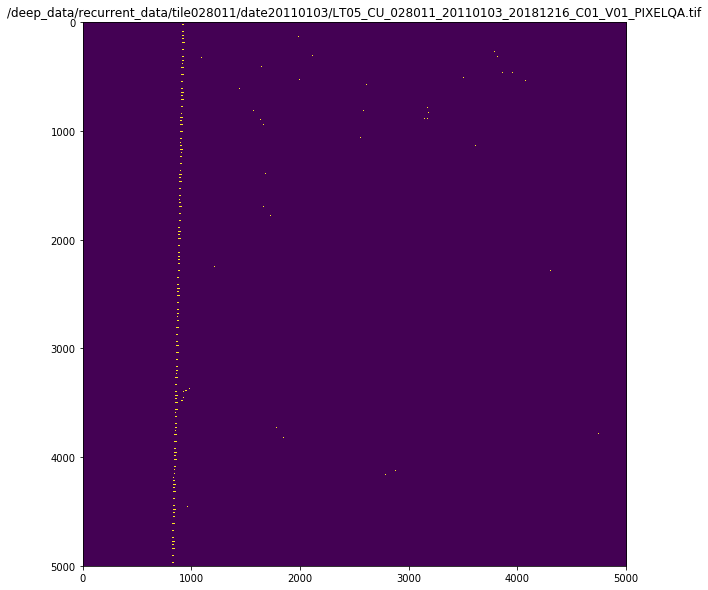

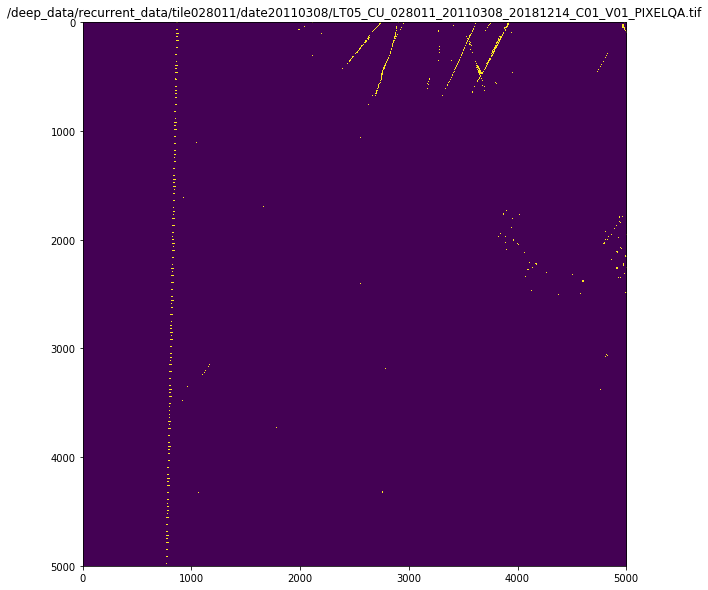

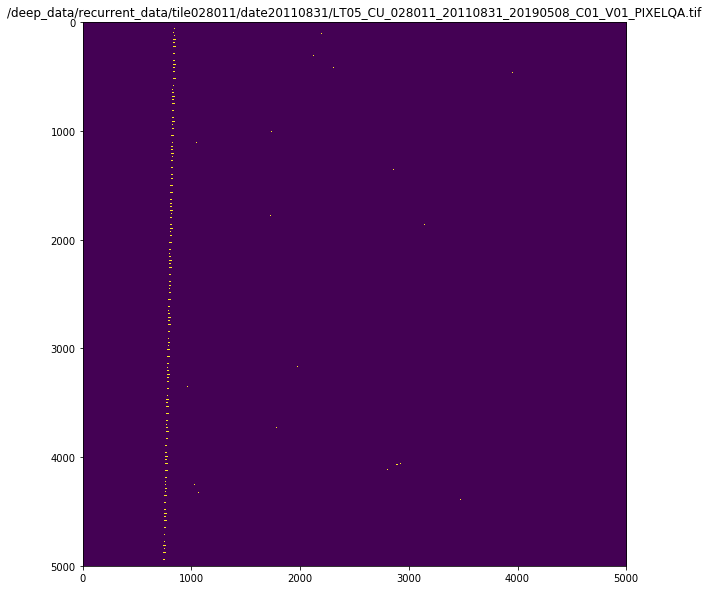

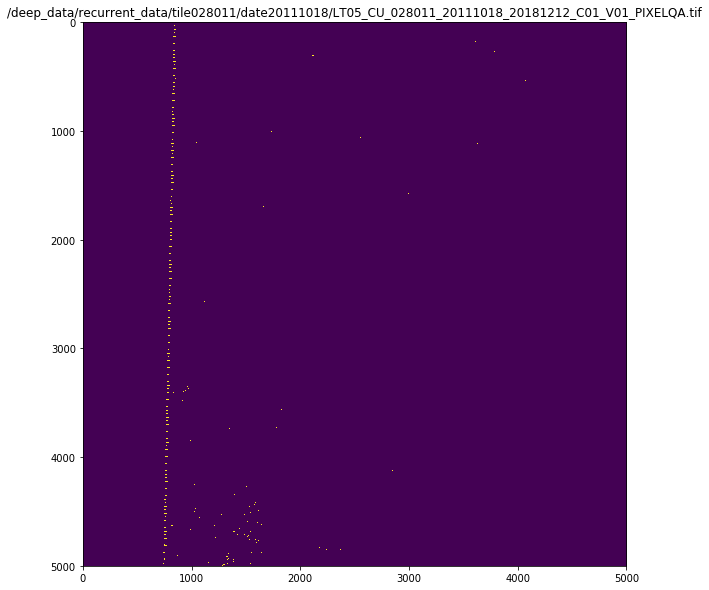

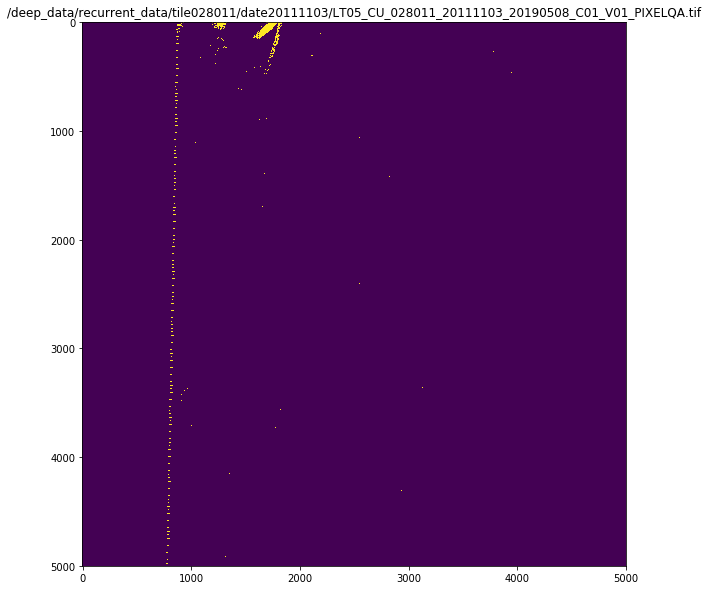

In [22]:
pixqa_cloud = np.zeros([5000,5000])

for pixqa in qa_fps[2]:
    pixqa_raster = rasterio.open(pixqa)
    pixqa_array = pixqa_raster.read()[0]

    pixqa_array[pixqa_array != 224] = 0
    pixqa_array[pixqa_array == 224] = 1
    

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(pixqa_array)
    ax.set_title(pixqa)
    
    pixqa_cloud = pixqa_cloud + pixqa_array

In [32]:
landsat_datasets = {}
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

View some of the images

(3, 5000, 5000)
(3, 5000, 5000)
(3, 5000, 5000)
(3, 5000, 5000)


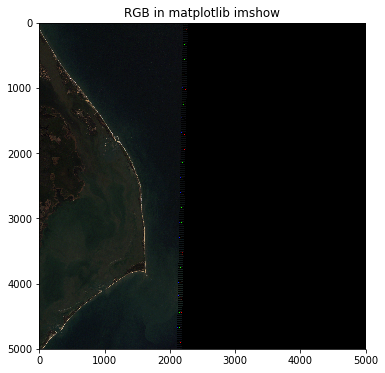

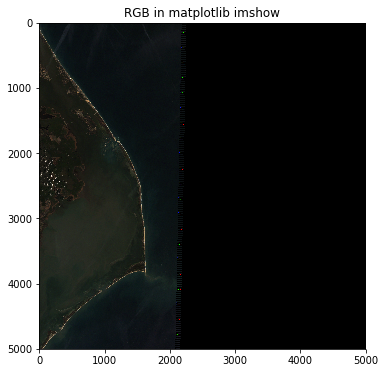

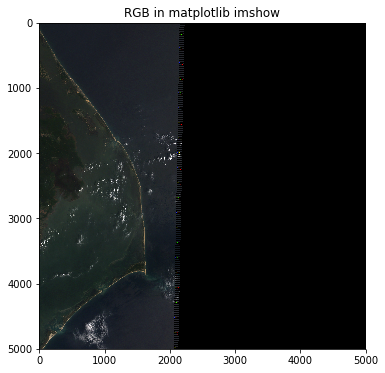

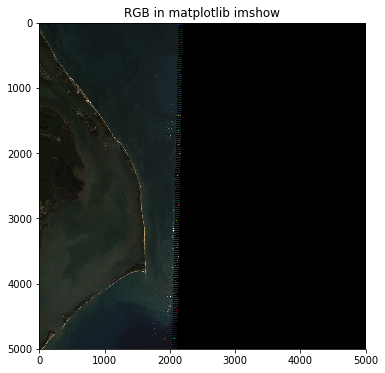

In [35]:
view_landsat(landsat_datasets['029011'][0])
view_landsat(landsat_datasets['029011'][1])
view_landsat(landsat_datasets['029011'][2])
view_landsat(landsat_datasets['029011'][3])
view_landsat(landsat_datasets['029011'][4])

(3, 5000, 5000)
(3, 5000, 5000)
(3, 5000, 5000)
(3, 5000, 5000)


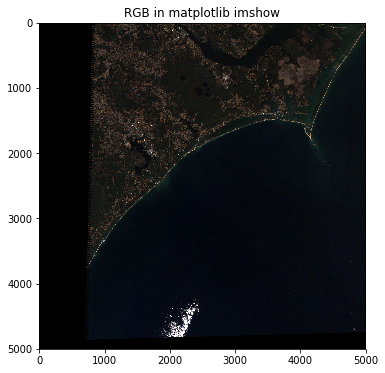

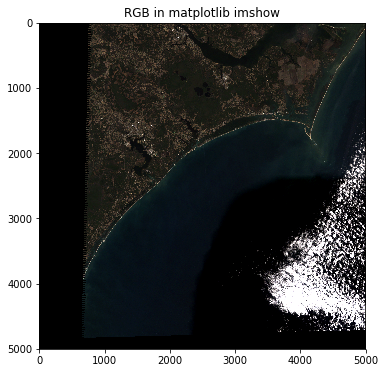

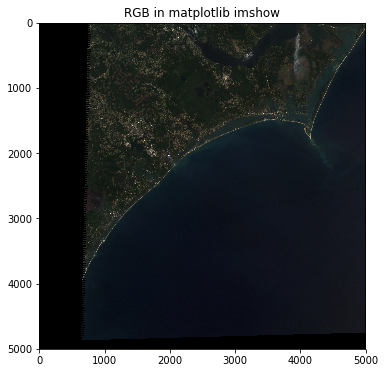

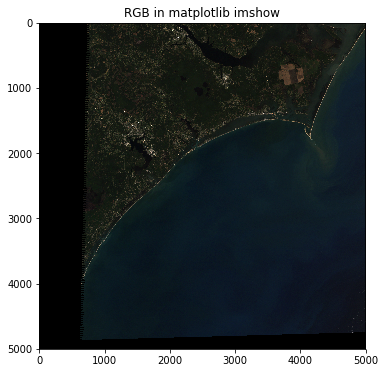

In [36]:
view_landsat(landsat_datasets['028012'][0])
view_landsat(landsat_datasets['028012'][1])
view_landsat(landsat_datasets['028012'][2])
view_landsat(landsat_datasets['028012'][3])
view_landsat(landsat_datasets['028012'][4])

In [26]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [9]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

In [12]:
tile_size = 64
tile_list = ['028012', '029011', '028011']

In [25]:
import rnn_tiles
import importlib
importlib.reload(rnn_tiles)
importlib.reload(rnn_pixels)

<module 'rnn_pixels' from '/host/Desktop/cnn_dev/florence_mapping/rcnn/rnn_pixels.py'>

In [26]:
pixels = rnn_pixels.make_pixels(tile_size, tile_list)
new_px = rnn_pixels.delete_bad_tiles(landsat_datasets, lc_labels, canopy_labels, pixels, 64)

In [28]:
print(len(new_px))

3576


In [17]:
print(len(new_px))

3873


In [68]:
plt.close('all')

In [10]:
gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, 64, 6)

In [11]:
generator = gen.tile_generator(new_px, 1)

NameError: name 'new_px' is not defined

In [124]:
l8_data, labels = next(generator)

In [125]:
l8_data = l8_data.reshape((4, 64, 64, 7))

(3, 64, 64)


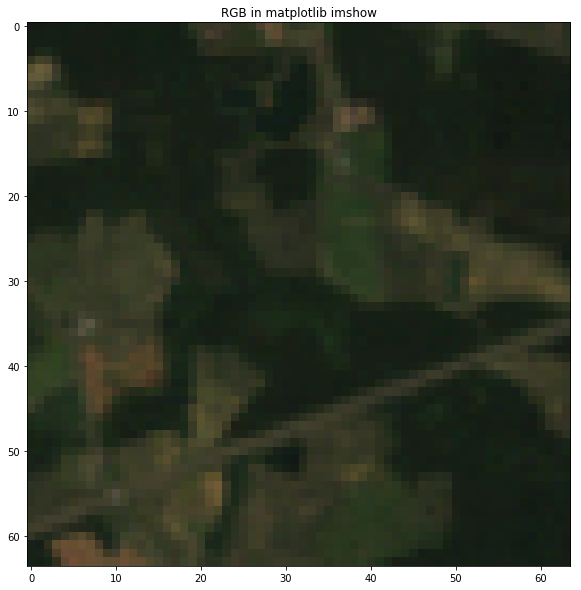

In [126]:
view_landsat(reshape_as_raster(l8_data[1]))

In [131]:
def show_labels(label):
    label = np.argmax(labels, axis=-1)
    label = label.reshape(64, 64)
    color_label = np.zeros((64, 64, 3))
    colors = {0:(0,0,255), 1:(255, 0, 0), 2:(0, 255, 0), 3:(153, 153,0), 4:(255,255, 255), 5:(0, 153, 153)}
    for i in range(64):
        for j in range(64):
            color_label[i][j] = colors[label[i][j]]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(color_label)
    ax.set_title("RGB in matplotlib imshow")

In [188]:
label.shape

(64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB in matplotlib imshow')

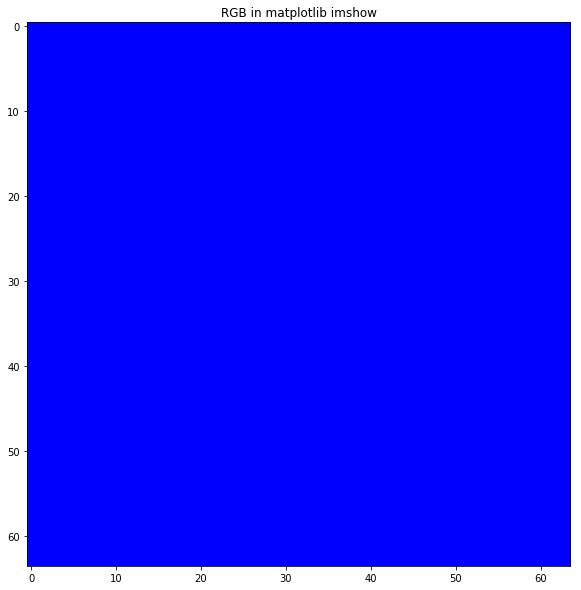

In [92]:
print("{}".format(lc_labels.height))
print("{}".format(lc_labels.width))

104424
161190


In [76]:
print(r)

(4960, 4960)


In [93]:
l8, labels = next(generator)

[[0.97 0.98 0.97 ... 0.   0.   0.  ]
 [0.95 0.94 0.98 ... 0.   0.   0.  ]
 [0.89 0.98 0.98 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.24]
 [0.   0.   0.   ... 0.   0.   0.52]]
1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2
[[0.94 0.91 0.95 ... 0.98 0.98 0.96]
 [0.96 0.9  0.99 ... 0.95 0.95 0.96]
 [0.96 0.99 0.92 ... 0.95 0.92 0.95]
 ...
 [0.84 0.89 0.95 ... 0.92 0.93 0.91]
 [0.85 0.71 0.92 ... 0.93 0.93 0.94]
 [0.45 0.65 0.74 ... 0.93 0.93 0.86]]
3
[[0.86 0.91 0.9  ... 0.98 0.98 0.99]
 [0.86 0.94 0.9  ... 0.99 1.   1.  ]
 [0.86 0.94 0.9  ... 1.   0.99 1.  ]
 ...
 [0.96 0.96 0.96 ... 0.95 0.97 0.92]
 [0.99 0.98 0.96 ... 0.93 0.92 0.95]
 [0.98 0.98 0.96 ... 0.96 0.95 0.93]]
4
[[0.35 0.75 0.86 ... 0.9  0.91 0.9 ]
 [0.32 0.37 0.82 ... 0.92 0.9  0.91]
 [0.26 0.22 0.74 ... 0.91 0.91 0.88]
 ...
 [0.97 0.94 0.98 ... 0.32 0.29 0.76]

In [28]:
points = make_pixels(64)

In [38]:
new_px = rnn_pixels.delete_bad_tiles(landsat_datasets, points, 64)

In [39]:
len(new_px)

6143

In [11]:
list_of_data = []
for key, item in landsat_datasets.items():
    list_of_data.append(item)

In [13]:
all_l8 = []
for lists in list_of_data:
    for item in lists:
        all_l8.append(item)
    

In [28]:
band_totals = np.zeros(7)
std_totals = np.zeros(7)
for l8 in all_l8:
    img = l8.read()
    img[img == -9999] = 0
    for i in range(7):
        band_totals[i] += np.mean(img[i])
        std_totals[i] += np.std(img[i])

In [29]:
band_totals / 12

array([  345.72448081,   352.93755735,   319.34257128,   899.39728239,
         649.46125258,   370.53562465, -1084.8218946 ])

In [32]:
std_totals / 12

array([ 661.75737932,  363.32761072,  425.28671553,  959.63442896,
        838.86193201,  501.96992987, 3562.42995552])